<a href="https://colab.research.google.com/github/lucinnnal/GANs/blob/main/Generative_Adversarial_Networks_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image # 텐서를 이미지로 변환하고 지정된 경로에 저장할 수 있도록 도와줍니다.

In [ ]:
"""
torchvision.utils.save_image(
    tensor,             # 저장할 텐서
    filename,           # 저장될 파일 경로 (파일명 포함)
    nrow=1,             # 한 행에 표시할 이미지 수 (배열 형식 저장 시)
    padding=2,          # 이미지 간의 패딩 (픽셀 단위)
    normalize=False,    # 정규화 여부 (True로 설정 시, [0, 1] 범위로 스케일링)
    range=None,         # 정규화 범위 (normalize=True일 때 유효)
    scale_each=False,   # 각 이미지별로 정규화 여부
    pad_value=0         # 패딩 영역의 값 (기본값: 0)
)
"""

'\ntorchvision.utils.save_image(\n    tensor,             # 저장할 텐서\n    filename,           # 저장될 파일 경로 (파일명 포함)\n    nrow=1,             # 한 행에 표시할 이미지 수 (배열 형식 저장 시)\n    padding=2,          # 이미지 간의 패딩 (픽셀 단위)\n    normalize=False,    # 정규화 여부 (True로 설정 시, [0, 1] 범위로 스케일링)\n    range=None,         # 정규화 범위 (normalize=True일 때 유효)\n    scale_each=False,   # 각 이미지별로 정규화 여부\n    pad_value=0         # 패딩 영역의 값 (기본값: 0)\n)\n'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Generator
latent_dim = 100 # (noise vector dimension)

class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    # the blocks that are appended to the layers (MLP)
    def block(input_dim, output_dim, normalize = True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(output_dim, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace = True)) # inplace = True 는 tensor 그 자체를 변환 시켜준다.
      return layers

    self.model = nn.Sequential(
        *block(latent_dim, 128, normalize = False),
        *block(128, 256),
        *block(256, 512),
        *block(512,1024),
        nn.Linear(1024, 1 * 28 * 28), # final image tensor creation
        nn.Tanh() # range from -1 to 1 shape = [batch_size, 1 * 28 * 28]
    )

  def forward(self, z):
    image = self.model(z)
    image = image.view(image.size(0), 1, 28, 28) # image creation (flatten -> 3d tensor)
    return image

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(1*28*28, 512),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(256,1),
        nn.Sigmoid()
    )

  def forward(self, img):
    flatten = img.view(img.size(0), -1)
    result = self.model(flatten)
    return result

In [ ]:
# transforms
transforms = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers = 4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 897kB/s] 


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.39MB/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.to(device)

adversarial_loss = nn.BCELoss()
adversarial_loss.to(device)


lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr = lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr, betas=(0.5, 0.999))

Optimizer는 모델의 파라미터에 의존
optimizer는 모델의 파라미터를 참조하며, 이 파라미터들이 이미 올바른 디바이스에 위치하고 있기 때문에, optimizer 자체를 별도로 다른 디바이스로 이동시킬 필요가 없습니다.

In [ ]:
import time

epochs = 200
sample_interval = 2000
start_time = time.time()

for epoch in range(epochs):
  for i, (imgs, _) in enumerate(dataloader):

    real = torch.FloatTensor(imgs.size(0), 1).fill_(1.0).to(device) # 진짜(real): 1
    fake = torch.FloatTensor(imgs.size(0), 1).fill_(0.0).to(device) # 가짜(fake): 0

    real_imgs = imgs.to(device)

    # Generator Training First
    optimizer_G.zero_grad()
    # noise sampling -> shape [batchsize, latent_dim]
    noise = torch.normal(mean = 0, std = 1, size = (imgs.shape[0], latent_dim)).to(device)

    # generate images
    generated_imgs = generator(noise)

    # generator loss calculation
    generator_loss = adversarial_loss(discriminator(generated_imgs), real) # the generator ones should be trained to create the images that's similar to real ones -> purpose : discriminator will assume it as 1(real).

    # backward & optimizer.step
    generator_loss.backward()
    optimizer_G.step()

    # Discriminator Training Second -> The discriminator should real -> 1, fakes -> 0
    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)

    D_loss = (real_loss + fake_loss) / 2

    D_loss.backward()
    optimizer_D.step()

    done = epoch * len(dataloader) + i # -> 현재까지 진행된 배치 수 출력!
    if done % sample_interval == 0:
        # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
        save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

  # 하나의 epoch이 끝날 때마다 로그(log) 출력
  print(f"[Epoch {epoch}/{epochs}] [D loss: {D_loss.item():.6f}] [G loss: {generator_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")


[Epoch 0/200] [D loss: 0.502041] [G loss: 0.966228] [Elapsed time: 16.93s]
[Epoch 1/200] [D loss: 0.586556] [G loss: 0.424154] [Elapsed time: 32.59s]
[Epoch 2/200] [D loss: 0.440869] [G loss: 0.715792] [Elapsed time: 48.88s]
[Epoch 3/200] [D loss: 0.332163] [G loss: 1.488542] [Elapsed time: 66.90s]
[Epoch 4/200] [D loss: 0.268628] [G loss: 1.496626] [Elapsed time: 84.20s]
[Epoch 5/200] [D loss: 0.210796] [G loss: 2.024996] [Elapsed time: 99.88s]
[Epoch 6/200] [D loss: 0.268943] [G loss: 1.162457] [Elapsed time: 116.05s]
[Epoch 7/200] [D loss: 0.532374] [G loss: 0.493675] [Elapsed time: 132.89s]
[Epoch 8/200] [D loss: 0.289610] [G loss: 2.647757] [Elapsed time: 149.83s]
[Epoch 9/200] [D loss: 0.294159] [G loss: 1.401614] [Elapsed time: 165.77s]
[Epoch 10/200] [D loss: 0.229754] [G loss: 1.999683] [Elapsed time: 185.89s]
[Epoch 11/200] [D loss: 0.299919] [G loss: 1.077437] [Elapsed time: 201.75s]
[Epoch 12/200] [D loss: 0.209720] [G loss: 1.401726] [Elapsed time: 217.50s]
[Epoch 13/200] 

**왜 generated_imgs.detach()를 사용하는가?**
GAN의 학습 과정에서, 생성자와 판별자는 동시에 학습됩니다. 하지만 각자의 손실 함수는 다른 역할을 합니다.
**discriminator**는 진짜 이미지와 가짜 이미지를 구별하는 학습을 합니다.
**generator**는 discriminator를 속이려고 가짜 이미지를 생성하는 학습을 합니다.
**discriminator는 가짜 이미지에 대한 손실을 계산할 때, generated_imgs.detach()**를 사용하여 generator의 기울기가 계산되지 않도록 합니다. 이렇게 하면 discriminator가 가짜 이미지에 대한 손실을 계산하는 데만 집중하게 되며, generator의 파라미터는 영향을 받지 않게 됩니다.
generator의 학습은 오직 generator가 생성한 이미지에 대한 손실만을 반영해야 하기 때문에, detached된 generated_imgs는 discriminator에서만 사용되고, generator의 기울기는 업데이트되지 않습니다.




-> discriminator를 학습할 때 generated_imgs 가 generator의 파라미터를 업데이트 하는데 영향을 미치지 않도록 하기 위해 사용됨. (generated_imgs 는 생성자에 의해 만들어진 텐서임을 고려)


# torch.cuda.FloatTensor와 to(device)를 혼용할 경우, **텐서의 장치(device)**와 데이터 타입이 일치하지 않으면 연산 중 문제가 발생할 수 있습니다. 특히, 텐서를 서로 다른 장치로 이동시키거나 텐서의 데이터 타입을 일관성 있게 맞추지 않으면 불일치로 인한 오류가 발생할 수 있습니다.

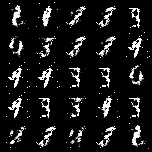

In [ ]:
# image test
from IPython.display import Image

Image('92000.png')